In [1]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体（显示中文）

from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder

import warnings
warnings.filterwarnings('ignore')

from importlib import reload
import utils
reload(utils)
from utils import seed_everything,get_data
seed_everything(2023)

In [2]:
info_map={
    'daily_min_temperatures.csv':{'freq':'d'},
    'weather.csv':{'freq':'10min'},
    'exchange_rate.csv':{'freq':'d'},
    'ETTh1.csv':{'freq':'h'},
    'traffic.csv':{'freq':'h'},
    'electricity.csv':{'freq':'h'},
}
class CFG:
    feature_pre_filter = False
    boosting_type = 'gbdt'
    objective = 'regression'
    metric = 'mse'
    seed = 2023
    n_jobs = -1
    verbose = -1

    path = 'electricity.csv'
    label = 'Temp' if path == 'daily_min_temperatures.csv' else 'OT'
    date_col = 'Date' if path == 'daily_min_temperatures.csv' else 'date'
    freq = info_map[path]['freq']
    scaler = ''
    num_boost_round = 10000
    early_stop_num = 5

    def keys(self):
        # 当用dict()将CFG类转为dict时，指定变量返回
        return {'feature_pre_filter', 'boosting_type', 'objective', 'metric', 'seed', 'n_jobs', 'verbose'} & {i for i in CFG.__dict__.keys()}

    def __getitem__(self, item):
        v = getattr(self, item)
        v = v[0] if isinstance(v,tuple) and len(v) == 1 else v
        return v

args=CFG()

In [3]:
data,train,valid,_ = get_data(args.path)
data=pd.DataFrame(data).reset_index()
train=pd.DataFrame(train).reset_index()

valid_start_date=valid.index.min()
valid_end_date=valid.index.max()

if args.scaler != '':
	assert args.scaler in ['minmax','std']
	if args.scaler == 'std':
		scaler = StandardScaler().fit(train[args.label].values.reshape(-1, 1))
	elif args.scaler == 'minmax':
		scaler = MinMaxScaler().fit(train[args.label].values.reshape(-1, 1))
		
	data[args.label] = scaler.transform(data[args.label].values.reshape(-1,1)).squeeze()

In [4]:
# 特征工程
def feature_engineering(data):
    df=data.copy()
    if args.path == 'electricity.csv':
        df['year']=df['date'].apply(lambda x:x.year)
        df['year']=LabelEncoder().fit_transform(df['year'])
        df['month']=df['date'].apply(lambda x:x.month - 1)
        df['week']=df['date'].apply(lambda x:x.weekday())
        df['day']=df['date'].apply(lambda x:x.day - 1)
        df['hour']=df['date'].apply(lambda x:x.hour)
        df['quarter']=df['month'].apply(lambda x:x//3)
        df['weeknum']=df['date'].apply(lambda x:x.isocalendar()[1] - 1)

        lags = 12
        for i in range(1,lags+1):
            df[f'shift_{i}']=df[args.label].shift(i)
        for i in range(2,lags+1):
            df[f'shift1_diff_{i}']=df['shift_1']-df[f'shift_{i}']
            df[f'shift1_mul_{i}']=df['shift_1']*df[f'shift_{i}']
            df[f'shift1_add_{i}']=df['shift_1']+df[f'shift_{i}']
            df[f'shift1_div_{i}']=df['shift_1']/df[f'shift_{i}']

        for i in [3, 6, 12, 18, 24, 30, 36, 40, 48]:
            if i > lags:
                break
            df[f'shift_min_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].min(axis=1)
            df[f'shift_max_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].max(axis=1)
            df[f'shift_mean_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].mean(axis=1)
            df[f'shift_std_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].std(axis=1)
            df[f'shift_median_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].median(axis=1)
            # df[f'shift_kurt_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].kurt(axis=1)
            # df[f'shift_skew_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].skew(axis=1)
    elif args.path == 'traffic.csv':
        df['year']=df['date'].apply(lambda x:x.year)
        df['year']=LabelEncoder().fit_transform(df['year'])
        df['month']=df['date'].apply(lambda x:x.month - 1)
        df['week']=df['date'].apply(lambda x:x.weekday())
        df['day']=df['date'].apply(lambda x:x.day - 1)
        df['hour']=df['date'].apply(lambda x:x.hour)
        df['quarter']=df['month'].apply(lambda x:x//3)
        df['weeknum']=df['date'].apply(lambda x:x.isocalendar()[1] - 1)

        lags = 36
        for i in range(1,lags+1):
            df[f'shift_{i}']=df[args.label].shift(i)
        for i in range(2,lags+1):
            df[f'shift1_diff_{i}']=df['shift_1']-df[f'shift_{i}']
            # df[f'shift1_mul_{i}']=df['shift_1']*df[f'shift_{i}']
            # df[f'shift1_add_{i}']=df['shift_1']+df[f'shift_{i}']
            # df[f'shift1_div_{i}']=df['shift_1']/df[f'shift_{i}']

        for i in [3, 6, 12, 18, 24, 30, 36, 40, 48]:
            if i > lags:
                break
            df[f'shift_min_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].min(axis=1)
            df[f'shift_max_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].max(axis=1)
            df[f'shift_mean_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].mean(axis=1)
            df[f'shift_std_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].std(axis=1)
            df[f'shift_median_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].median(axis=1)
            # df[f'shift_kurt_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].kurt(axis=1)
            # df[f'shift_skew_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].skew(axis=1)
    elif args.path == 'ETTh1.csv':
        df['year']=df['date'].apply(lambda x:x.year)
        df['year']=LabelEncoder().fit_transform(df['year'])
        df['month']=df['date'].apply(lambda x:x.month - 1)
        # df['week']=df['date'].apply(lambda x:x.weekday())
        # df['day']=df['date'].apply(lambda x:x.day - 1)
        df['hour']=df['date'].apply(lambda x:x.hour)
        # df['quarter']=df['month'].apply(lambda x:x//3)
        # df['weeknum']=df['date'].apply(lambda x:x.isocalendar()[1] - 1)

        lags = 24
        for i in range(1,lags+1):
            df[f'shift_{i}']=df[args.label].shift(i)
        for i in range(2,lags+1):
            df[f'shift1_diff_{i}']=df['shift_1']-df[f'shift_{i}']
            df[f'shift1_mul_{i}']=df['shift_1']*df[f'shift_{i}']
            df[f'shift1_add_{i}']=df['shift_1']+df[f'shift_{i}']
            df[f'shift1_div_{i}']=df['shift_1']/df[f'shift_{i}']

        for i in [3, 6, 12, 18, 24, 30, 36, 40, 48]:
            if i > lags:
                break
            df[f'shift_min_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].min(axis=1)
            df[f'shift_max_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].max(axis=1)
            df[f'shift_mean_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].mean(axis=1)
            df[f'shift_std_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].std(axis=1)
            df[f'shift_median_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].median(axis=1)
            # df[f'shift_kurt_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].kurt(axis=1)
            # df[f'shift_skew_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].skew(axis=1)
    elif args.path == 'exchange_rate.csv':
        df['year']=df['date'].apply(lambda x:x.year)
        df['year']=LabelEncoder().fit_transform(df['year'])
        df['month']=df['date'].apply(lambda x:x.month - 1)
        df['week']=df['date'].apply(lambda x:x.weekday())
        df['day']=df['date'].apply(lambda x:x.day - 1)
        df['quarter']=df['month'].apply(lambda x:x//3)

        lags = 30
        for i in range(1,lags+1):
            df[f'shift_{i}']=df[args.label].shift(i)
        for i in range(2,lags+1):
            df[f'shift1_diff_{i}']=df['shift_1']-df[f'shift_{i}']
            df[f'shift1_mul_{i}']=df['shift_1']*df[f'shift_{i}']
            # df[f'shift1_add_{i}']=df['shift_1']+df[f'shift_{i}']
            # df[f'shift1_div_{i}']=df['shift_1']/df[f'shift_{i}']

        for i in [3, 6, 12, 18, 24, 30, 36, 40, 48]:
            if i > lags:
                break
            df[f'shift_min_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].min(axis=1)
            df[f'shift_max_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].max(axis=1)
            df[f'shift_mean_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].mean(axis=1)
            df[f'shift_std_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].std(axis=1)
            # df[f'shift_median_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].median(axis=1)
            # df[f'shift_kurt_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].kurt(axis=1)
            # df[f'shift_skew_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].skew(axis=1)
    elif args.path == 'weather.csv':
        df['month']=df['date'].apply(lambda x:x.month - 1)
        df['week']=df['date'].apply(lambda x:x.weekday())
        df['day']=df['date'].apply(lambda x:x.day - 1)
        df['hour']=df['date'].apply(lambda x:x.hour)
        df['minute']=df['date'].apply(lambda x:x.minute)
        df['quarter']=df['month'].apply(lambda x:x//3)

        lags = 12
        for i in range(1,lags+1):
            df[f'shift_{i}']=df[args.label].shift(i)
        for i in range(2,lags+1):
            df[f'shift1_diff_{i}']=df['shift_1']-df[f'shift_{i}']
            df[f'shift1_mul_{i}']=df['shift_1']*df[f'shift_{i}']
            df[f'shift1_add_{i}']=df['shift_1']+df[f'shift_{i}']
            df[f'shift1_div_{i}']=df['shift_1']/df[f'shift_{i}']

        for i in [3, 6, 12, 18, 24, 30, 36, 40, 48]:
            if i > lags:
                break
            df[f'shift_min_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].min(axis=1)
            df[f'shift_max_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].max(axis=1)
            df[f'shift_mean_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].mean(axis=1)
            df[f'shift_std_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].std(axis=1)
            df[f'shift_median_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].median(axis=1)
            df[f'shift_kurt_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].kurt(axis=1)
            df[f'shift_skew_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].skew(axis=1)
    elif args.path == 'daily_min_temperatures.csv':
        # df['year']=df['Date'].apply(lambda x:x.year)
        # df['year']=LabelEncoder().fit_transform(df['year'])
        df['month']=df['Date'].apply(lambda x:x.month - 1)
        df['week']=df['Date'].apply(lambda x:x.weekday())
        # df['weeknum']=df['Date'].apply(lambda x:x.isocalendar()[1] - 1)
        df['day']=df['Date'].apply(lambda x:x.day - 1)
        df['quarter']=df['month'].apply(lambda x:x//3)
        # df['date']=df['Date'].apply(lambda x:x.strftime('%m-%d'))
        # df['date']=LabelEncoder().fit_transform(df['date'])

        lags = 12
        for i in range(1,lags+1):
            df[f'shift_{i}']=df[args.label].shift(i)
        for i in range(2,lags+1):
            df[f'shift1_diff_{i}']=df['shift_1']-df[f'shift_{i}']
            # df[f'shift1_mul_{i}']=df['shift_1']*df[f'shift_{i}']
            # df[f'shift1_add_{i}']=df['shift_1']+df[f'shift_{i}']
            # df[f'shift1_div_{i}']=df['shift_1']/df[f'shift_{i}']

        for i in [3, 6, 12]:
            if i > lags:
                break
            df[f'shift_min_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].min(axis=1)
            df[f'shift_max_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].max(axis=1)
            df[f'shift_mean_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].mean(axis=1)
            df[f'shift_std_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].std(axis=1)
            df[f'shift_median_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].median(axis=1)
            # df[f'shift_kurt_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].kurt(axis=1)
            # df[f'shift_skew_{i}'] = df[[f'shift_{i}' for i in range(1, i+1)]].skew(axis=1)

    df = df.fillna(0)
    return df
    
data=feature_engineering(data)
if args.path == 'electricity.csv':
    train=data[data['date'].between(data['date'].min(),pd.to_datetime(valid_start_date) - datetime.timedelta(hours=1))].copy()
    valid=data[data['date'].between(pd.to_datetime(valid_start_date),pd.to_datetime(valid_end_date))].copy()
    test=data[data['date'].between(pd.to_datetime(valid_end_date) + datetime.timedelta(hours=1),data['date'].max())].copy()
    category_cols=['year', 'month', 'week', 'day', 'hour', 'quarter', 'weeknum']
elif args.path == 'traffic.csv':
    train=data[data['date'].between(data['date'].min(),pd.to_datetime(valid_start_date) - datetime.timedelta(hours=1))].copy()
    valid=data[data['date'].between(pd.to_datetime(valid_start_date),pd.to_datetime(valid_end_date))].copy()
    test=data[data['date'].between(pd.to_datetime(valid_end_date) + datetime.timedelta(hours=1),data['date'].max())].copy()
    category_cols=['year', 'month', 'week', 'day', 'hour', 'quarter', 'weeknum']
elif args.path == 'ETTh1.csv':
    train=data[data['date'].between(data['date'].min(),pd.to_datetime(valid_start_date) - datetime.timedelta(hours=1))].copy()
    valid=data[data['date'].between(pd.to_datetime(valid_start_date),pd.to_datetime(valid_end_date))].copy()
    test=data[data['date'].between(pd.to_datetime(valid_end_date) + datetime.timedelta(hours=1),data['date'].max())].copy()
    category_cols=['year', 'month', 'hour']
elif args.path == 'exchange_rate.csv':
    train=data[data['date'].between(data['date'].min(),pd.to_datetime(valid_start_date) - datetime.timedelta(days=1))].copy()
    valid=data[data['date'].between(pd.to_datetime(valid_start_date),pd.to_datetime(valid_end_date))].copy()
    test=data[data['date'].between(pd.to_datetime(valid_end_date) + datetime.timedelta(days=1),data['date'].max())].copy()
    category_cols=['year', 'month', 'week', 'day', 'quarter']
elif args.path == 'weather.csv':
    train=data[data['date'].between(data['date'].min(),pd.to_datetime(valid_start_date) - datetime.timedelta(minutes=10))].copy()
    valid=data[data['date'].between(pd.to_datetime(valid_start_date),pd.to_datetime(valid_end_date))].copy()
    test=data[data['date'].between(pd.to_datetime(valid_end_date) + datetime.timedelta(minutes=10),data['date'].max())].copy()
    category_cols=['month', 'week', 'day', 'hour', 'minute', 'quarter']
elif args.path == 'daily_min_temperatures.csv':
    train=data[data['Date'].between(data['Date'].min(),pd.to_datetime(valid_start_date) - datetime.timedelta(days=1))].copy()
    valid=data[data['Date'].between(pd.to_datetime(valid_start_date),pd.to_datetime(valid_end_date))].copy()
    test=data[data['Date'].between(pd.to_datetime(valid_end_date) + datetime.timedelta(days=1),data['Date'].max())].copy()
    category_cols=['month', 'week', 'day', 'quarter']

feat_cols=[i for i in data.columns if i not in [args.date_col,args.label]]
print('len(feat_cols) :',len(feat_cols))

len(feat_cols) : 78


In [5]:
tra = lgb.Dataset(train[feat_cols],train[args.label])
val = lgb.Dataset(valid[feat_cols],valid[args.label])
model = lgb.train(dict(args), tra, valid_sets=[tra,val],
                num_boost_round=args.num_boost_round,categorical_feature=category_cols,
                callbacks=[lgb.early_stopping(args.early_stop_num), lgb.log_evaluation(args.early_stop_num)])

Training until validation scores don't improve for 5 rounds
[5]	training's l2: 120628	valid_1's l2: 94391
[10]	training's l2: 54308.9	valid_1's l2: 43565.3
[15]	training's l2: 30201.3	valid_1's l2: 25449.6
[20]	training's l2: 20976.3	valid_1's l2: 18717.7
[25]	training's l2: 17124.1	valid_1's l2: 16452.2
[30]	training's l2: 15304.7	valid_1's l2: 15431.7
[35]	training's l2: 14176.5	valid_1's l2: 14817.8
[40]	training's l2: 13399.9	valid_1's l2: 14425.6
[45]	training's l2: 12837.8	valid_1's l2: 14133.9
[50]	training's l2: 12320.8	valid_1's l2: 13842.8
[55]	training's l2: 11941.4	valid_1's l2: 13626.2
[60]	training's l2: 11602.9	valid_1's l2: 13515.4
[65]	training's l2: 11290	valid_1's l2: 13358.6
[70]	training's l2: 11014.5	valid_1's l2: 13324.9
[75]	training's l2: 10725.5	valid_1's l2: 13305.1
Early stopping, best iteration is:
[73]	training's l2: 10838.4	valid_1's l2: 13218.8


In [6]:
true_cases = test[args.label].values
predicted_cases = model.predict(test[feat_cols], num_iteration=model.best_iteration)

true_cases_valid = valid[args.label].values
predicted_cases_valid = model.predict(valid[feat_cols], num_iteration=model.best_iteration)

true_cases_all = data[args.label].values
predicted_cases_all = model.predict(data[feat_cols], num_iteration=model.best_iteration)

if args.scaler != '':
	true_cases = scaler.inverse_transform(np.expand_dims(true_cases, axis=0)).flatten()
	predicted_cases = scaler.inverse_transform(np.expand_dims(predicted_cases, axis=0)).flatten()

	true_cases_valid = scaler.inverse_transform(np.expand_dims(true_cases_valid, axis=0)).flatten()
	predicted_cases_valid = scaler.inverse_transform(np.expand_dims(predicted_cases_valid, axis=0)).flatten()

	true_cases_all = scaler.inverse_transform(np.expand_dims(true_cases_all, axis=0)).flatten()
	predicted_cases_all = scaler.inverse_transform(np.expand_dims(predicted_cases_all, axis=0)).flatten()

print(f'all: mse={mean_squared_error(true_cases_all,predicted_cases_all)} mae={mean_absolute_error(true_cases_all,predicted_cases_all)}')
print(f'valid: mse={mean_squared_error(true_cases_valid,predicted_cases_valid)} mae={mean_absolute_error(true_cases_valid,predicted_cases_valid)}')
print(f'test: mse={mean_squared_error(true_cases,predicted_cases)} mae={mean_absolute_error(true_cases,predicted_cases)}')

# electricity
# all: mse=10836.975562192134 mae=70.46449349257963
# valid: mse=13218.842894951182 mae=72.56172005731455
# test: mse=8199.309950612304 mae=66.86454854056491

# traffic
# all: mse=6.709008135121095e-06 mae=0.0015533317092562256
# valid: mse=4.970026928705406e-05 mae=0.0032516173974058197
# test: mse=7.342092654106043e-06 mae=0.0020069614111440665

# ETTh1
# all: mse=0.5760284332918885 mae=0.514231784622053
# valid: mse=0.35816386115843823 mae=0.35838861836796687
# test: mse=0.32002368188285035 mae=0.364134917854779

# exchange_rate
# all: mse=2.2726996006671543e-05 mae=0.003197154147985736
# valid: mse=2.0568504636073058e-05 mae=0.0032441261871736667
# test: mse=2.1149857394950875e-05 mae=0.0025256382219895125

# weather
# all: mse=6.294548594068139 mae=1.368195691656397
# valid: mse=1.4434825169081589 mae=0.8763568393712452
# test: mse=1.6507375551903587 mae=0.8167546493608637

# daily_min_temperatures
# all: mse=4.339431964743159 mae=1.6335664977147377
# valid: mse=5.05086647611983 mae=1.8041600166666014
# test: mse=4.836091594359972 mae=1.5431264031611909

all: mse=10836.975562192134 mae=70.46449349257963
valid: mse=13218.842894951182 mae=72.56172005731455
test: mse=8199.309950612304 mae=66.86454854056491


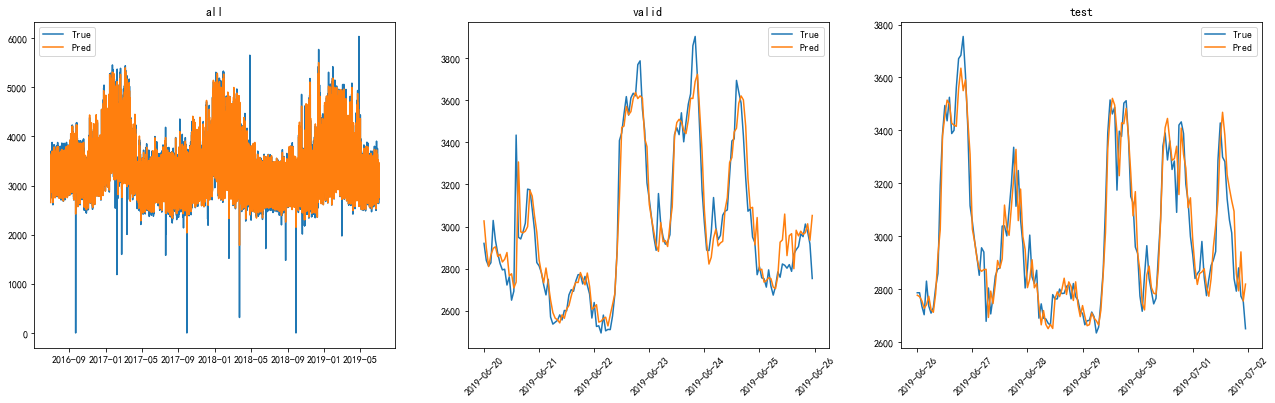

In [7]:
fig,ax=plt.subplots(1,3,figsize=(22,6))
ax[0].plot(data[args.date_col],true_cases_all,label='True')
ax[0].plot(data[args.date_col],predicted_cases_all,label='Pred')
ax[0].set_title('all')
ax[0].legend()
ax[1].plot(valid[args.date_col],true_cases_valid,label='True')
ax[1].plot(valid[args.date_col],predicted_cases_valid,label='Pred')
ax[1].set_title('valid')
ax[1].legend()
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].plot(test[args.date_col],true_cases,label='True')
ax[2].plot(test[args.date_col],predicted_cases,label='Pred')
ax[2].set_title('test')
ax[2].legend()
ax[2].tick_params(axis='x', labelrotation=45)
plt.show()

100%|██████████| 72/72 [01:22<00:00,  1.15s/it]


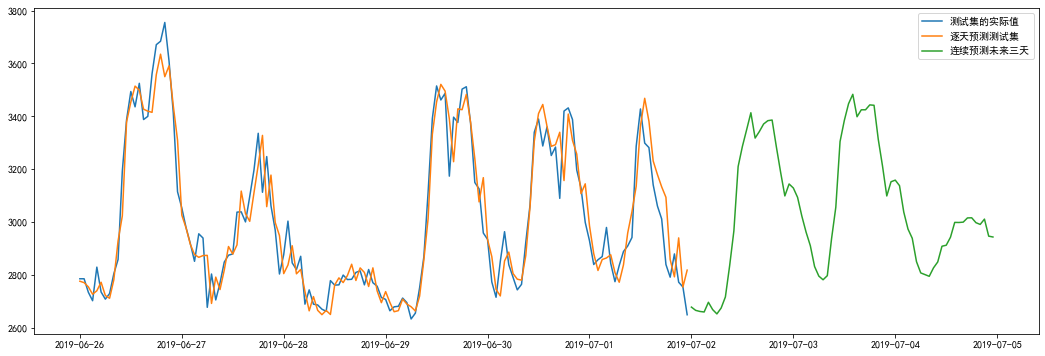

In [8]:
# 根据验证集按天迭代预测测试集
DAYS_TO_PREDICT = len(test)
test_pred = pd.concat([train[[args.date_col,args.label]],valid[[args.date_col,args.label]]],ignore_index=True)
preds = []
for i in tqdm(range(DAYS_TO_PREDICT)):
    if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
        pred_date = valid_end_date+datetime.timedelta(hours=i+1)
    elif args.path == 'weather.csv':
        pred_date = valid_end_date+datetime.timedelta(minutes=(i+1)*10)
    elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
        pred_date = valid_end_date+datetime.timedelta(days=i+1)
    test_pred = pd.concat([test_pred,pd.DataFrame([[pred_date,0]],columns=[args.date_col,args.label])],ignore_index=True)
    valid_pred_feature = feature_engineering(test_pred)
    pred = model.predict(valid_pred_feature.iloc[-1][feat_cols].values.reshape(1,-1), num_iteration=model.best_iteration)
    test_pred.loc[test_pred[args.date_col] == pred_date,args.label] = test.loc[test[args.date_col] == pred_date,args.label].values[0]
    preds.append(pred.item())

if args.scaler != '':
    preds = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
forcast_df1=pd.Series(preds,name=args.label)
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    forcast_df1.index=pd.date_range(start=valid[args.date_col].max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path == 'weather.csv':
    forcast_df1.index=pd.date_range(start=valid[args.date_col].max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    forcast_df1.index=pd.date_range(start=valid[args.date_col].max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT)
forcast_df1.index.name=args.date_col

# 根据测试集按天迭代预测接下来的时间
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    DAYS_TO_PREDICT = 3 * 24
    label='连续预测未来三天'
elif args.path == 'weather.csv':
    DAYS_TO_PREDICT = 1 * 6 * 24
    label='连续预测未来一天'
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    DAYS_TO_PREDICT = 31
    label='连续预测未来一个月'
future_pred = data[[args.date_col,args.label]].copy()
preds = []
for i in tqdm(range(DAYS_TO_PREDICT)):
    if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
        pred_date = data[args.date_col].max()+datetime.timedelta(hours=i+1)
    elif args.path == 'weather.csv':
        pred_date = data[args.date_col].max()+datetime.timedelta(minutes=(i+1)*10)
    elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
        pred_date = data[args.date_col].max()+datetime.timedelta(days=i+1)
    future_pred = pd.concat([future_pred,pd.DataFrame([[pred_date,0]],columns=[args.date_col,args.label])],ignore_index=True)
    valid_pred_feature = feature_engineering(future_pred)
    pred = model.predict(valid_pred_feature.iloc[-1][feat_cols].values.reshape(1,-1), num_iteration=model.best_iteration)
    future_pred.loc[future_pred[args.date_col] == pred_date,args.label] = pred.item()
    preds.append(pred.item())

if args.scaler != '':
    preds = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
forcast_df2=pd.Series(preds,name=args.label)
if args.path in ['ETTh1.csv','traffic.csv','electricity.csv']:
    forcast_df2.index=pd.date_range(start=data[args.date_col].max()+datetime.timedelta(hours=1),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path == 'weather.csv':
    forcast_df2.index=pd.date_range(start=data[args.date_col].max()+datetime.timedelta(minutes=10),periods=DAYS_TO_PREDICT,freq=args.freq)
elif args.path in ['daily_min_temperatures.csv','exchange_rate.csv']:
    forcast_df2.index=pd.date_range(start=data[args.date_col].max()+datetime.timedelta(days=1),periods=DAYS_TO_PREDICT)
forcast_df2.index.name=args.date_col

fig,ax=plt.subplots(1,1,figsize=(18,6))
ax.plot(test[args.date_col],test[args.label],label='测试集的实际值')
ax.plot(forcast_df1.index,forcast_df1.values,label='逐天预测测试集')
ax.plot(forcast_df2.index,forcast_df2.values,label=label)
ax.legend()
plt.show()